In [1]:
import torch
import matplotlib.pyplot as plt

dtype = torch.float
device = 'cpu'

In [2]:
input = torch.tensor([[[[2, 3, 3.5]]]], dtype=dtype, device=device, requires_grad=True)
space = torch.linspace(-4, 4, 4*8 + 1, dtype=torch.float, device=device)
grid = torch.stack([space, torch.zeros_like(space)], dim=-1)[None, None, :]
grid.requires_grad_(True)
output = torch.nn.functional.grid_sample(input, grid, align_corners=True)
output.backward(torch.ones_like(output))

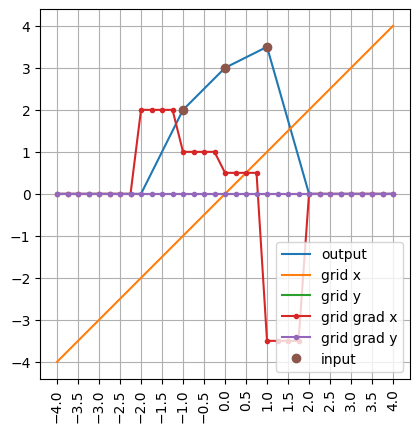

In [3]:
plt.plot(space, output.detach().flatten(), label='output')
plt.plot(space, grid[..., 0].detach().flatten(), label='grid x')
plt.plot(space, grid[..., 1].detach().flatten(), label='grid y')
plt.plot(space, grid.grad[..., 0].detach().flatten(), marker='.', label='grid grad x')
plt.plot(space, grid.grad[..., 1].detach().flatten(), marker='.', label='grid grad y')
plt.plot(torch.linspace(-1, 1, input.numel()), input.detach().flatten(), marker='o', linestyle='', label='input')

plt.grid()
ax = plt.gca()
ticks = torch.linspace(space[0].item(), space[-1].item(), int((space[-1].item() - space[0].item()) / 0.5) + 1).tolist()
ax.set_xticks(ticks)
ax.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.axis('square')
plt.show()

Key insight: `grid.grad[..., d]` tells you the slope in dimension `d` used in the single-value interpolation step. I explained in a comment that to calculate a single value of `output` for 3D linear interpolation, we can imagine a unit cube, the corners of which we assign a field value, and the field has a constant gradient inside that cube. `grid.grad` tells you what that gradient was, for each element of `output`.

But I think (not sure) that there might be a scaling factor between the unit cube's gradient and `grid.grad`, since in the Metal impl I scaled the values of `grid`. We would just need to apply the inverse of that scaling operation to the gradient.

In [4]:
input.grad

tensor([[[[4., 4., 4.]]]])

Each `input.grad` element is a sum of the factors by which each element of `output` depended on that element of `input`. So let's say that three elements, A, B, and C, of the output of a grid sampler call depended on one particular input element I by factors of 1, 0.5, and 0, respectively.

That would mean that output element A landed directly on I, and so A was exactly equal to I.

B landed directly in the middle of one of the edges of its unit cube, and B is the middle average between I and some other input element. 

C landed directly on one of the corners of its unit cube, but it wasn't I.

The gradient value for I will then depend on the sum of 1, 0.5, and 0. However, of course it is a weighted average, where the weights are the corresponding `output.grad` elements.